In [1]:
# Appearance adjustment
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

In [2]:
# Imports
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm.notebook import tqdm

from tools import ballsINTObins, RMSELoss, train_epoch, valid_epoch, test_epoch, simulator


ModuleNotFoundError: No module named 'tools'

In [ ]:
# Define - Dataset, Model, calc_acc, dataset_creation, Sim Params Class, RMSELoss
    
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, samples, labels):
        
        super(Dataset, self).__init__()

        self.dataset = []
        
        for sample, label in zip(samples, labels):
            self.dataset.append((torch.tensor(sample).float(), torch.tensor(label).float()))

    def __getitem__(self, index):
                                        
        return self.dataset[index]
        
    def __len__(self):
        
        return len(self.dataset)


    
class MLP(nn.Module):

    def __init__(self, num_in, num_out):
        super().__init__()
        
        self.network = nn.Sequential(nn.Linear(num_in, 32),
                                     nn.ReLU(),
#                                      nn.Dropout(0.1),
                                     nn.Linear(32, 64),
                                     nn.ReLU(),
#                                      nn.Dropout(0.1),
                                     nn.Linear(64, 64),
                                     nn.ReLU(),
#                                      nn.Dropout(0.1),
                                     nn.Linear(64, num_out),
                                     nn.Sigmoid())
    def forward(self, x):
        return self.network(x)

    
    
# def calculate_accuracy(all_preds, all_labels):

#     accuracy = 0
#     for i, (pred, label) in enumerate(zip(all_preds, all_labels)):
        
#         pred = np.argmax(pred)
        
#         if(pred == label):
#             accuracy = accuracy + 1
    
#     return accuracy / (i + 1)



def ballsINTObins(m, n):

    if m==0:
        return np.zeros((1, n))
    
    if n==1:
        return np.asarray([m])
    
    all_rest = []
    for i in range(m+1):
        rest = ballsINTObins(m-i, n-1)
        all_rest.append(np.c_[np.ones(rest.shape[0])*i, rest])
    
    result = np.concatenate(all_rest, axis=0)
    return result



class Parameters:
    def __init__(self, air_trans_file, air_RI, atm_dist_ratio, basis_func_file,
                 num_substances, spectra_file, substances_emit_file):
        self.air_trans_file = air_trans_file
        self.air_RI = air_RI
        self.atm_dist_ratio = atm_dist_ratio
        self.basis_func_file = basis_func_file
        self.num_substances = num_substances
        self.spectra_file = spectra_file
        self.substances_emit_file = substances_emit_file
        
        
        
def RMSELoss(predict, target):
    return torch.sqrt(torch.mean((predict-target)**2))

In [25]:
# Epochs definition

# def train_epoch(model, device, dataloader, criterions, optimizer):
#     # Support for nultiple criterion functions - MSE for training and others for error display.
#     train_loss = [0 for criterion in criterions]
#     model.train()
    
#     for samples, labels in dataloader:
#         samples, labels = samples.to(device), labels.to(device)
        
#         optimizer.zero_grad()
        
#         output = model(samples)
        
#         # Training criterion is the last in the list, so that the loss could be used directly for back prop.
#         for i, criterion in enumerate(criterions):
#             loss = criterion(output, labels)
#             train_loss[i] += loss.item() * samples.size(0)
        
#         loss.backward()
#         optimizer.step()
        
#     return np.asarray(train_loss)



# def valid_epoch(model, device, dataloader, criterions):
#     valid_loss = [0 for criterion in criterions]
#     model.eval()
    
#     for samples, labels in dataloader:
#         samples, labels = samples.to(device), labels.to(device)
        
#         output = model(samples)
        
#         for i, criterion in enumerate(criterions):
#             loss = criterion(output, labels)
#             valid_loss[i] += loss.item() * samples.size(0)
        
#     return np.asarray(valid_loss)



# def test_epoch(model, device, dataloader, criterions):
#     test_loss = [0 for criterion in criterions]
#     pred_list = []
#     targ_list = []
    
#     model.eval()
    
#     for samples, labels in dataloader:
#         samples, labels = samples.to(device), labels.to(device)
        
#         output = model(samples)
        
#         pred_list.append(output.detach().numpy())
#         targ_list.append(labels.detach().numpy())
        
#         for i, criterion in enumerate(criterions):
#             loss = criterion(output, labels)
#             test_loss[i] += loss.item() * samples.size(0)
            
#     return np.asarray(test_loss), pred_list, targ_list

In [26]:
def add_noise(signal, percentage):
    perc_array = np.ones(signal.shape)
    rand_array = np.random.rand(signal.shape[0]) * percentage
    perc_array = perc_array + rand_array
    
    out = signal * perc_array
    
    return out

In [27]:
# Simulation parameters
   
sim_params = Parameters(air_trans_file='./data/Test 2 - 21 Substances/Air transmittance.xlsx',
                        air_RI=1,
                        atm_dist_ratio=0.11,
                        basis_func_file='./data/Test 2 - 21 Substances/Basis functions.xlsx',
                        num_substances=4,
                        spectra_file='./data/Test 2 - 21 Substances/spectra.xlsx',
                        substances_emit_file='./data/Test 2 - 21 Substances/substances.xlsx')


# Enviroment related parameters
temp_K = 293.15 # Environmental temperature in K
air_trans = np.array(pd.read_excel(sim_params.air_trans_file, header=None))
air_trans = air_trans[:, 1:]
atm_dist_ratio = sim_params.atm_dist_ratio # Atomsphere distance ratio
air_RI = sim_params.air_RI # Refractive index of air

# Sensor related parameters
basis_funcs = np.array(pd.read_excel(sim_params.basis_func_file, header=None))
basis_funcs = basis_funcs[:, 1:]

# Substance related parameters
num_substances = sim_params.num_substances
spectra = np.array(pd.read_excel(sim_params.spectra_file, header=None))
substances_emit = np.array(pd.read_excel(sim_params.substances_emit_file, header=None))
substances_emit = substances_emit[:, 0:sim_params.num_substances]
# Material mixture proportion
mat_proportion = ballsINTObins(10, sim_params.num_substances).transpose() / 10
# mat_proportion = np.array(pd.read_excel('./data/Test 2 - 21 Substances/proportion_NN_test.xlsx', header=None))

data = []
labels = []
for i in range(mat_proportion.shape[1]):
    weights = mat_proportion[:, i]
    mat_em = np.average(substances_emit, weights=weights, axis=1)
    mat_em = np.expand_dims(mat_em, 1)
    out = simulator(spectra, mat_em, temp_K, air_trans, atm_dist_ratio, air_RI, basis_funcs)
    
    for i in range(1, 6):
        out = add_noise(out, i/100)
        data.append(out)
    labels.append(weights)


test_data = []
test_labels = []
for i in range(mat_proportion.shape[1]):
    weights = mat_proportion[:, i]
    mat_em = np.average(substances_emit, weights=weights, axis=1)
    mat_em = np.expand_dims(mat_em, 1)
    out = simulator(spectra, mat_em, temp_K, air_trans, atm_dist_ratio, air_RI, basis_funcs)
    
    
    out = add_noise(out, 3/100)
    test_data.append(out)
    test_labels.append(weights)

In [28]:
# Training parameters
dataset = Dataset(data, labels)

batch_size = len(data) // 10

train_percentage = 0.8
train_size = int(train_percentage * len(data))
test_size = len(dataset) - train_size
torch.manual_seed(28)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

criterions = [nn.L1Loss(), RMSELoss, nn.MSELoss()]

learning_rate = 1e-3

num_epochs = 1000

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps")
device = torch.device("cpu")

k = 5
kfold = KFold(n_splits=k, shuffle=True)


test_dataset = Dataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [29]:
# Train - k fold

history = []
models = []

for fold, (train_ids, valid_ids) in enumerate(kfold.split(train_dataset)):
    print(f'\nFOLD {fold + 1}')
#     print('--------------------------------')
    train_subsampler = SubsetRandomSampler(train_ids)
    valid_subsampler = SubsetRandomSampler(valid_ids)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    valid_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=valid_subsampler)

    model = MLP(num_in=basis_funcs.shape[1], num_out=sim_params.num_substances)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model_loss_records = {'train_loss': [], 'valid_loss': []}
    for epoch in tqdm(range(num_epochs)):
        train_loss = train_epoch(model, device, train_loader, criterions, optimizer)
        valid_loss = valid_epoch(model, device, valid_loader, criterions)
        
        train_loss = train_loss / len(train_loader.sampler)
        valid_loss = valid_loss / len(valid_loader.sampler)
        
        model_loss_records['train_loss'].append(train_loss)
        model_loss_records['valid_loss'].append(valid_loss)
        
    model_loss_records['train_loss'] = np.asarray(model_loss_records['train_loss'])
    model_loss_records['valid_loss'] = np.asarray(model_loss_records['valid_loss'])
    history.append(model_loss_records)
    models.append(model)
        
#         print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Valid Loss:{:.3f} ".format(epoch + 1,
#                                                                                    num_epochs,
#                                                                                    train_loss,
#                                                                                    valid_loss))



FOLD 1


  0%|          | 0/1000 [00:00<?, ?it/s]


FOLD 2


  0%|          | 0/1000 [00:00<?, ?it/s]


FOLD 3


  0%|          | 0/1000 [00:00<?, ?it/s]


FOLD 4


  0%|          | 0/1000 [00:00<?, ?it/s]


FOLD 5


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

0.10471258810838567
0.29880152324488113
0.25037937570675894


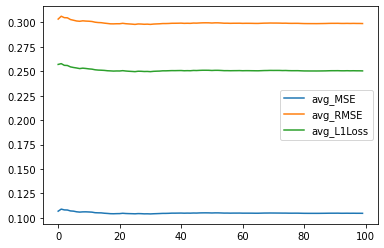

In [30]:
# Base line

epoch = 100

MSE = []
avg_MSE = []
RMSE = []
avg_RMSE = []
L1Loss = []
avg_L1Loss = []


mseloss = nn.MSELoss()
l1loss = nn.L1Loss()

for i in tqdm(range(epoch)):
    
    target_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    pred_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    pred_loader_iter = iter(pred_loader)

    for x, target in target_loader:

        xx, pred = next(pred_loader_iter)

        MSE.append(mseloss(pred, target).item())
        RMSE.append(RMSELoss(pred, target).item())
        L1Loss.append(l1loss(pred, target).item())
        
    avg_MSE.append(np.mean(MSE))
    avg_RMSE.append(np.mean(RMSE))
    avg_L1Loss.append(np.mean(L1Loss))

print(avg_MSE[-1])
print(avg_RMSE[-1])
print(avg_L1Loss[-1])

plt.plot(avg_MSE)
plt.plot(avg_RMSE)
plt.plot(avg_L1Loss)

plt.legend(['avg_MSE', 'avg_RMSE', 'avg_L1Loss'])


avg loss = 0.12030799239873886
best loss = 0.10505615174770355
best model index = 1


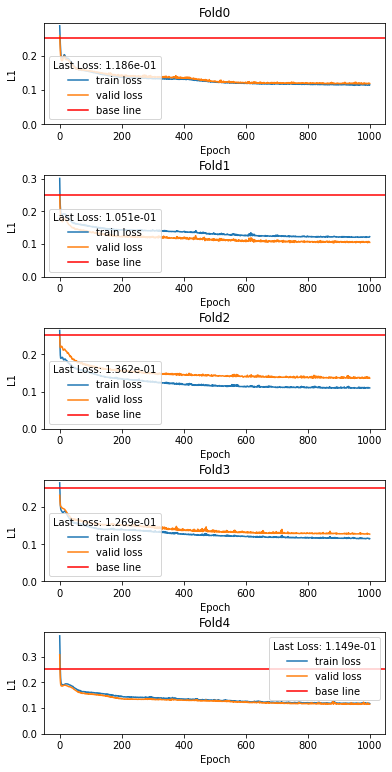

In [31]:
# Plot k fold
fig, axs = plt.subplots(k, figsize=(6, 11))
fig.tight_layout(pad=3)
# np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
loss = []
loss_func_index = 0
base_line_loss = [avg_L1Loss[-1], avg_RMSE[-1], avg_MSE[-1]]
base_line_names = ['L1', 'RMSE', 'MSE']
# avg_loss = 0
for i in range (5):
    axs[i].plot(history[i]['train_loss'][:, loss_func_index])
    axs[i].plot(history[i]['valid_loss'][:, loss_func_index])
    axs[i].axhline(base_line_loss[loss_func_index], color='r')
    
    axs[i].set_ylim(bottom=0)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel(base_line_names[loss_func_index])
    
    axs[i].legend(['train loss', 'valid loss', 'base line'], 
                  title=f'Last Loss: {"{:0.3e}".format(history[i]["valid_loss"][:, loss_func_index][-1])}')
    
    axs[i].set_title('Fold' + str(i))
    
    loss.append(history[i]["valid_loss"][:, loss_func_index][-1])
    
    
#     avg_loss += history[i]["valid_loss"][-1]
    
avg_loss = np.mean(loss)
best_loss = np.min(loss)
best_model_index = np.argmin(loss)

print("avg loss =", avg_loss)
print("best loss =", best_loss)
print("best model index =", best_model_index)

[ 65.82  78.83  25.73]
Target:  [[ 0.00  0.20  0.00  0.80]]
Predict: [[ 0.06  0.67  0.15  0.15]] 

Target:  [[ 0.00  0.20  0.10  0.70]]
Predict: [[ 0.09  0.57  0.18  0.18]] 

Target:  [[ 0.00  0.20  0.20  0.60]]
Predict: [[ 0.11  0.40  0.23  0.23]] 

Target:  [[ 0.00  0.20  0.30  0.50]]
Predict: [[ 0.12  0.28  0.29  0.32]] 

Target:  [[ 0.00  0.20  0.40  0.40]]
Predict: [[ 0.14  0.18  0.36  0.37]] 

Target:  [[ 0.00  0.20  0.50  0.30]]
Predict: [[ 0.15  0.14  0.40  0.38]] 

Target:  [[ 0.00  0.20  0.60  0.20]]
Predict: [[ 0.15  0.14  0.39  0.36]] 

Target:  [[ 0.00  0.20  0.70  0.10]]
Predict: [[ 0.16  0.15  0.39  0.34]] 

Target:  [[ 0.00  0.20  0.80  0.00]]
Predict: [[ 0.16  0.30  0.27  0.26]] 

Target:  [[ 0.00  0.30  0.00  0.70]]
Predict: [[ 0.19  0.55  0.13  0.14]] 

0.11855780333280563


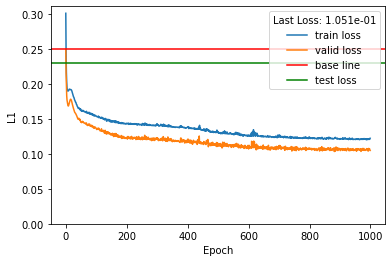

In [32]:
# Plot k fold test result

criterions = [nn.L1Loss(reduction='mean'), RMSELoss, nn.MSELoss()]

model = models[best_model_index]
test_loss, pred_list, targ_list = test_epoch(model, device, test_loader, criterions)

print(test_loss)

loss_func_index = 0
base_line_loss = [avg_L1Loss[-1], avg_RMSE[-1], avg_MSE[-1]]

test_loss = test_loss / len(test_dataset)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(history[best_model_index]['train_loss'][:, loss_func_index])
ax.plot(history[best_model_index]['valid_loss'][:, loss_func_index])

ax.axhline(base_line_loss[loss_func_index], color='r')
ax.axhline(y=test_loss[loss_func_index], color='g')
    
# ax.plot(avg_RMSE)
# ax.plot(avg_L1Loss)

ax.set_ylim(bottom=0)
ax.set_xlabel('Epoch')
ax.set_ylabel(base_line_names[loss_func_index])
ax.legend(['train loss', 'valid loss', 'base line', 'test loss'], 
          title=f'Last Loss: {"{:0.3e}".format(history[best_model_index]["valid_loss"][:, loss_func_index][-1])}')

np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
for i in range(21,31):
    print('Target: ', targ_list[i])
    print('Predict:', pred_list[i], '\n')
print(loss[loss_func_index])